# 京东JData算法大赛(2)-数据分析

In [5]:
# 导入相关包
%matplotlib inline
# 绘图包
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [6]:
# 定义文件名
ACTION_201602_FILE = "data/JData_Action_201602.csv"
ACTION_201603_FILE = "data/JData_Action_201603.csv"
ACTION_201603_EXTRA_FILE = "data/JData_Action_201603_extra.csv"
ACTION_201604_FILE = "data/JData_Action_201604.csv"
COMMENT_FILE = "data/JData_Comment.csv"
PRODUCT_FILE = "data/JData_Product.csv"
USER_FILE = "data/JData_User.csv"
NEW_USER_FILE = "data/JData_User_New.csv"
USER_TABLE_FILE = "data/user_table.csv"
ITEM_TABLE_FILE = "data/item_table.csv"

### 周一到周日各天购买情况

In [3]:
# 提取购买(type=4)的行为数据
def get_from_action_data(fname, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4,为购买
    df_ac = df_ac[df_ac['type'] == 4]

    return df_ac[["user_id", "sku_id", "time"]]

In [4]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_EXTRA_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped
Iteration is stopped


In [5]:
print(df_ac.dtypes)

user_id     int64
sku_id      int64
time       object
dtype: object


In [6]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1)

In [7]:
# 周一到周日每天购买用户个数
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['weekday', 'user_num']

In [8]:
# 周一到周日每天购买商品个数
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['weekday', 'item_num']

In [9]:
# 周一到周日每天购买记录个数
df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['weekday', 'user_item_num']

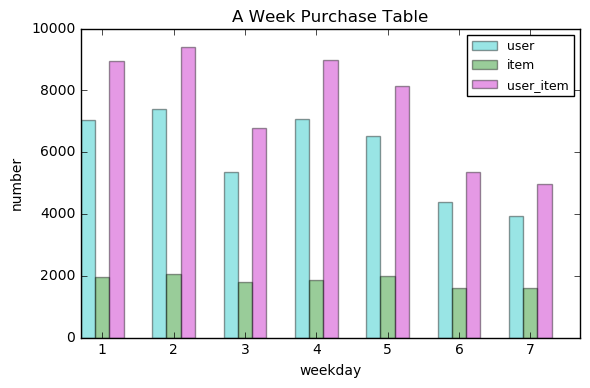

In [10]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4

plt.bar(df_user['weekday'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['weekday']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['weekday']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')

plt.xlabel('weekday')
plt.ylabel('number')
plt.title('A Week Purchase Table')
plt.xticks(df_user['weekday'] + bar_width * 3 / 2., (1,2,3,4,5,6,7))
plt.tight_layout() 
plt.legend(prop={'size':9})

**分析**: 一周用户购买数量分布相对比较均衡,周六周日购买数相对较少,可能是此时大家都去过周末玩了,而平时可以逛京东作为消遣.

### 一个月各天购买情况

#### 2016年2月

In [11]:
df_ac = get_from_action_data(fname=ACTION_201602_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [12]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']

df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

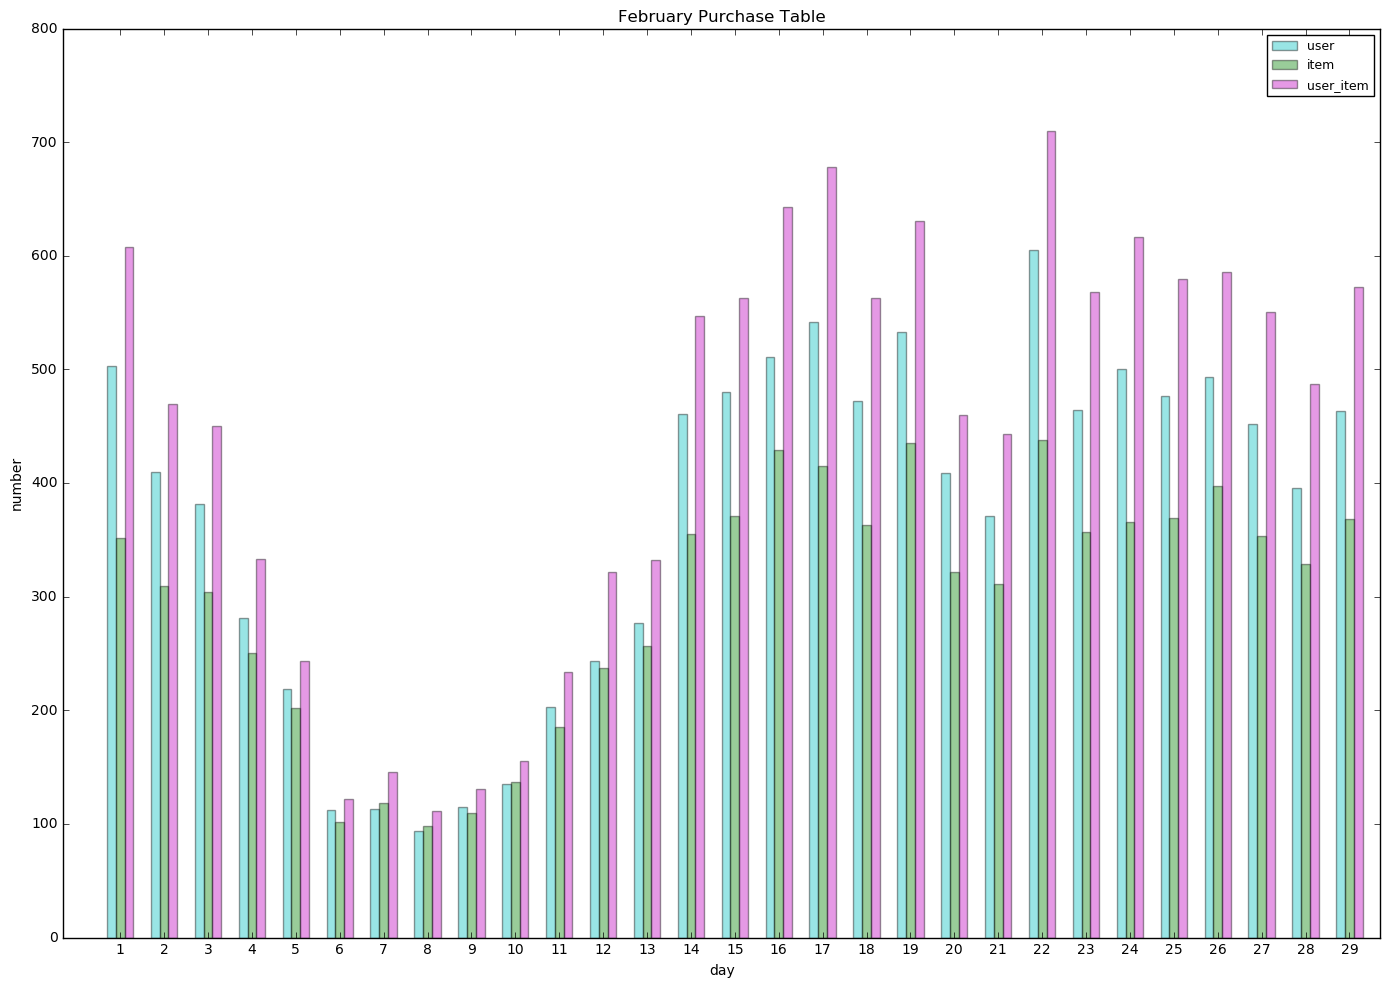

In [13]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')

plt.xlabel('day')
plt.ylabel('number')
plt.title('February Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

**分析**: 从上面可以发现,在2月6号到2月10号之间是我们的农历新年,快递在这几天不上班,因而购物数量相对较少,在我们实际分析时, 可以暂时将这部分数据作为异常数据不去考虑,不加入我们的训练样本中.

#### 查看特定用户对特定商品的活动轨迹

In [7]:
def spec_ui_action_data(fname, user_id, item_id, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    df_ac = df_ac[(df_ac['user_id'] == user_id) & (df_ac['sku_id'] == item_id)]

    return df_ac

In [8]:
def explore_user_item_via_time():
    user_id = 62969
    item_id = 62655
    df_ac = []
    df_ac.append(spec_ui_action_data(ACTION_201602_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201603_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(
        ACTION_201603_EXTRA_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201604_FILE, user_id, item_id))

    df_ac = pd.concat(df_ac, ignore_index=False)
    print(df_ac.sort_values(by='time'))

In [9]:
explore_user_item_via_time()

Iteration is stopped
Iteration is stopped
Iteration is stopped
Iteration is stopped
       user_id  sku_id  type                 time
12296    62969   62655     1  2016-02-01 11:00:05
12307    62969   62655     1  2016-02-01 11:00:05
12300    62969   62655     2  2016-02-01 11:00:18
12285    62969   62655     1  2016-02-01 11:00:49
12305    62969   62655     1  2016-02-01 11:00:49
12302    62969   62655     2  2016-02-01 11:02:16
12294    62969   62655     1  2016-02-01 11:02:17
12304    62969   62655     1  2016-02-01 11:02:17
12297    62969   62655     1  2016-02-01 11:03:47
12306    62969   62655     1  2016-02-01 11:03:47
12303    62969   62655     4  2016-02-01 11:04:00


> 预测数据部分: 2016-04-16到2016-04-20用户是否下单P中的商品，每个用户只会下单一个商品；

  由于我们需要预测16-20号五天用户的购买情况,那我们不妨分析下用户以5天为单位(周期为5)购买情况.